# Intensity over z

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import pandas as pd
import glob
import os
from scipy.interpolate import interp1d

def loadCSVFeatures(file):
    with open(file) as f:
        row_count = 0
        row = f.readline()
        while row.startswith('#'):
            row = f.readline()
            row_count += 1
    metadata = pd.read_csv(file, skiprows=row_count, nrows=1, index_col=0).to_dict('records')[0]
    features = pd.read_csv(file, skiprows=row_count + 2, index_col=0)
    return features, metadata
from skimage.transform import resize
%matplotlib widget

In [2]:
import h5py
from tqdm import tqdm
allbeads_refstack = h5py.File("FinalRefstack_allbeads_latdrift_corr_min20_temp.mat")
refstack = np.array(allbeads_refstack["Refstack"])

In [ ]:
x0,y0=259,256
def potential(x,y,r):
    r_sq = ((x-x0)**2+(y-y0)**2)
    cond = r_sq > r**2 and r_sq <= (r+1)**2
    dist = np.abs(np.sqrt(r_sq)-r)
    return np.exp(-0.5*dist**2)
    # return cond
masks = []
def discrete_potential(x,y,r):
    r_sq = ((x-x0)**2+(y-y0)**2)
    cond = r_sq > r**2 and r_sq <= (r+1)**2
    return cond
for r in tqdm(range(x0)):
    obj = np.zeros_like(refstack[0], dtype=np.float32)
    for (y,x),val in np.ndenumerate(obj):
        obj[y,x] = potential(x,y,r)
    masks.append(obj)
np.save("masks_0.5.npy",np.array(masks))

100%|██████████| 259/259 [01:48<00:00,  2.39it/s]


In [219]:
masks=np.load("masks_0.5.npy")
masks=masks/masks.sum(axis=0)
outside = np.isnan(masks)
masks[outside] = 0

z_stack = np.zeros((len(refstack), x0))
masks_normalized = (masks.T/masks.sum(axis=(1,2))).T
for i,ripple in (enumerate(tqdm(refstack))):
    for j,mask in enumerate(masks_normalized):
        z_stack[i,j] = np.sum(ripple*mask)
np.save("z_stack_0.5.npy", z_stack)

/var/folders/39/51hl1qv962dgjs7r9mznnsxm0000gp/T/ipykernel_18323/1348773548.py:2: RuntimeWarning: invalid value encountered in divide
  masks=masks/masks.sum(axis=0)
100%|██████████| 1568/1568 [00:32<00:00, 48.40it/s]


/tmp/ipykernel_1047281/2984351123.py:3: RuntimeWarning: invalid value encountered in divide
  masks=masks/masks.sum(axis=0)


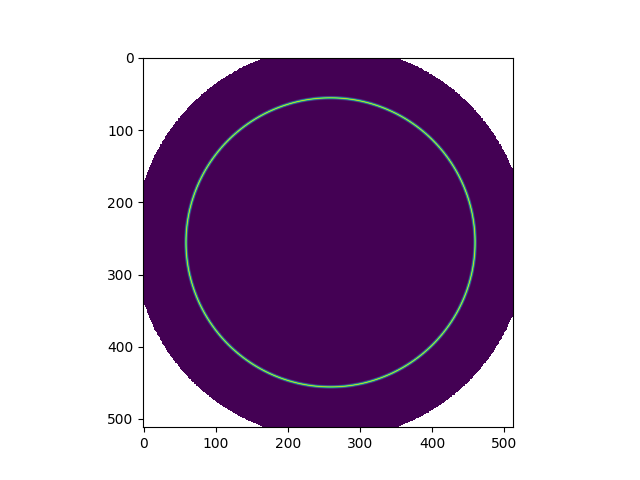

In [3]:
z_stack = np.load("z_stack_0.5.npy")
masks=np.load("masks_0.5.npy")
masks=masks/masks.sum(axis=0)
outside = np.isnan(masks)
# masks[outside] = 2e4
plt.imshow(masks[200])
plt.show()


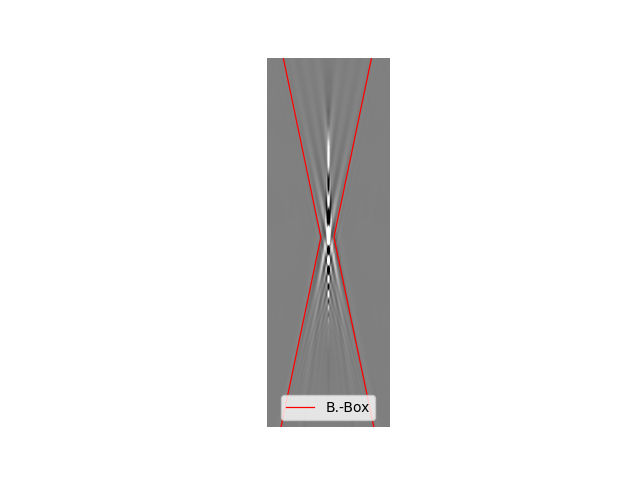

In [13]:
# plt.close('all')
# plt.figure()
plt.clf()
z_mirrored = np.concat([z_stack[:,::-1],z_stack],axis=1)
plt.imshow(z_mirrored,vmin=1.85e4,vmax=2.15e4,cmap="grey")
z = np.arange(len(z_stack))
bbox = np.abs(z-761)*0.21+55/2
plt.plot(bbox+256,z,"r",lw=0.9,label="B.-Box")
plt.plot(-bbox+256,z,"r",lw=0.9)
plt.axis("off")
plt.legend(loc="lower center")
plt.show()

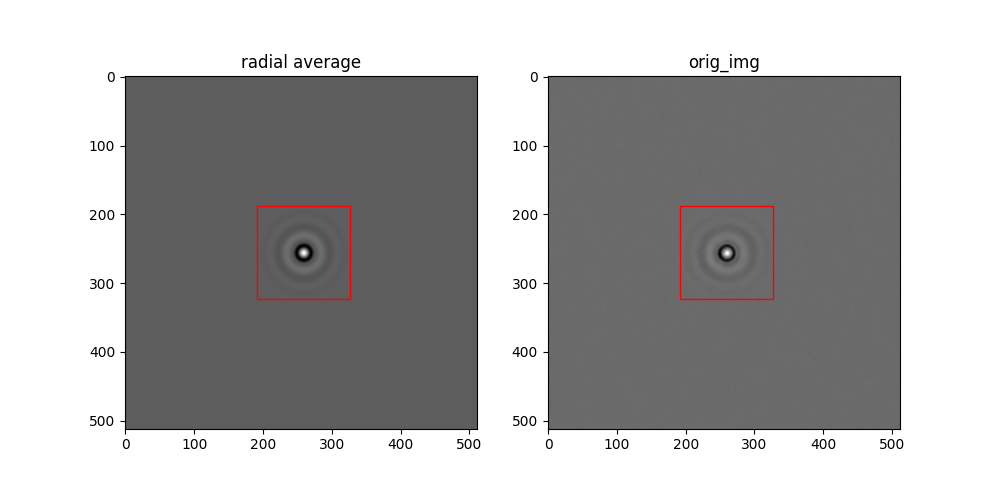

In [19]:
from matplotlib import colormaps as cmaps
from matplotlib.patches import Rectangle
def averaged_z_stack(z):
    ripple = np.sum([(masks[i]*z_stack[z,i]) for i in range(len(z_stack[0]))],axis=0)
    ripple[outside[0]] = 2e4
    return ripple
plt.close("all")
plt.figure(figsize=(10,5))
z=700
plt.subplot(1,2,1)
plt.title("radial average")
plt.imshow(averaged_z_stack(z),cmap=cmaps["Greys"])
x0,y0 = 259,256
bbox_width = np.abs(z-761)*0.21+55
rectangle = Rectangle((x0-bbox_width,y0-bbox_width),bbox_width*2,bbox_width*2,edgecolor="red",facecolor="none")
plt.figure(1).axes[0].add_patch(rectangle)

# plt.imshow(masks[100],cmap=cmaps["Greys"])
# plt.imshow(np.isnan(masks).sum(axis=0))
plt.subplot(1,2,2)
plt.title("orig_img")
plt.imshow(refstack[z],cmap=cmaps["Greys"])
rectangle = Rectangle((x0-bbox_width,y0-bbox_width),bbox_width*2,bbox_width*2,edgecolor="red",facecolor="none")

plt.figure(1).axes[1].add_patch(rectangle)

plt.show()

In [34]:
from multiprocessing.pool import Pool
ripples_downsampled = np.empty((len(z_stack),128,128))
def make_downsampled(z):
    return z, resize(averaged_z_stack(z),(128,128))

In [35]:
with Pool() as pool:
    for z, ripple in tqdm(pool.imap(make_downsampled,range(len(z_stack))),total=len(z_stack)):
        ripples_downsampled[z] = ripple

100%|██████████| 1568/1568 [01:38<00:00, 15.99it/s]


In [36]:
np.save("ripples_downsampled.npy", ripples_downsampled)